In [38]:
import torch
import os
import subprocess

repo_root = subprocess.check_output(["git", "rev-parse", "--show-toplevel"]).decode().strip()
os.chdir(repo_root)

print("cwd =", os.getcwd())

from solvers.torch_eit_fem_solver import EIT
from solvers.torch_eit_fem_solver.fem import Mesh, V_h, dtn_map
from solvers.torch_eit_fem_solver.utils import dtn_from_sigma
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import cmocean as cmo
from scipy import io as sio
from tqdm import tqdm
from models.unet import Unet
from collections import OrderedDict
import numpy as np

device = 'cuda:1' 
data = torch.load('data/eit-circles-dataset-128.pt')

train_min = data["train"].min()
train_max = data["train"].max()


gt = data["test"][5].cpu()


cwd = /home/johnma/flow-inverse


## Notebook summary
The flow model here interpolates between standard noise and circles. It makes sense why PnP would fail miserably.
1. Consider that the flow model *wants* to interpolate between standard noise and circles. One thing that should alarm you is that standard noise is centered at 0, so you get negative values. That is assumedly pretty bad for your FEM model.
2. Have to think more about what PnP wants to do.

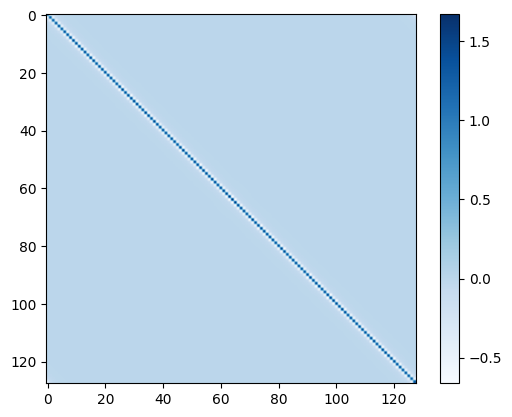

In [39]:
# load mesh
data_root = 'mesh-data'
mesh_file = 'mesh_128_h05.mat'
img_size = 128
original_size = 128
pad_size = 0

mat_fname  = os.path.join(data_root, mesh_file)
mat_contents = sio.loadmat(mat_fname)

p = torch.tensor(mat_contents['p'], dtype=torch.float64).to(device)
t = torch.tensor(mat_contents['t']-1, dtype=torch.long).to(device)
vol_idx = torch.tensor(mat_contents['vol_idx'].reshape((-1,))-1, dtype=torch.long).to(device)
bdy_idx = torch.tensor(mat_contents['bdy_idx'].reshape((-1,))-1, dtype=torch.long).to(device)

mesh = Mesh(p, t, bdy_idx, vol_idx)
v_h = V_h(mesh)

# get the dtn map
dtn_map = dtn_from_sigma(sigma_vec=gt, v_h=v_h, mesh=mesh, img_size=img_size, device=device)

plt.imshow(dtn_map.reshape((128, 128)).cpu().detach().numpy(), cmap='Blues')
plt.colorbar()


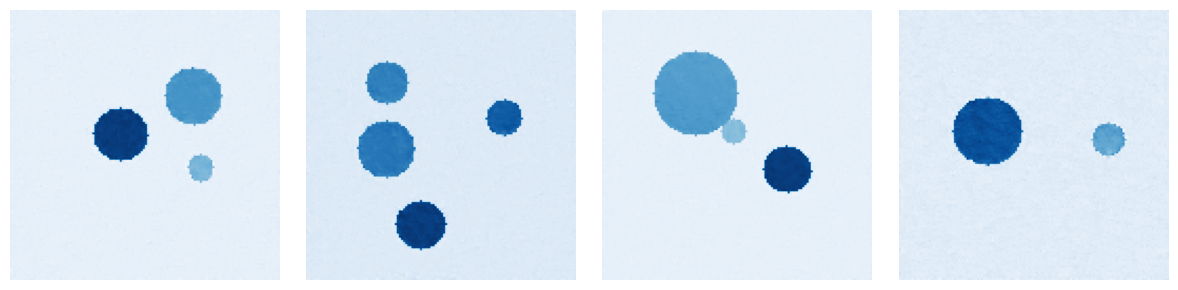

In [50]:
import copy
model = Unet(ch=32).to(device)
checkpoint = torch.load("saved_runs/circles-eit-v-pred/checkpoints/ckp_31500.tar", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
x0 = torch.randn(4, 1, 128, 128).to(device)

def v_field(z, t):
    t_batch = t.expand(z.shape[0])
    return model(z, t_batch)

timesteps = torch.linspace(0.0, 1.0, steps=5).to(device)
with torch.no_grad():
    pred = odeint(
        func=lambda t, x: v_field(x, t),
        t=timesteps,
        y0=x0,
        method='rk4',
        atol=1e-5,
        rtol=1e-5,
    )[-1]

# Unnormalize predictions
pred = 0.5 * (pred + 1.0) * (train_max - train_min) + train_min

fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    img = pred[i].squeeze().cpu().numpy()
    axes[i].imshow(img, cmap="Blues")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
loss_fn = torch.nn.MSELoss()
SIGMA_MIN = 1e-2
N = 20
gt = gt.squeeze()
t = torch.linspace(0., 1-SIGMA_MIN, N).to(device)
gamma = 1e-3
xi = torch.randn(img_size, img_size).to(device)
xn_trajectory = []
pbar = tqdm(range(N), desc='PnP solver iterating')
for i in pbar:
    xi = xi.requires_grad_()
    Fx = dtn_from_sigma(xi, v_h, mesh, img_size, device).squeeze(0).squeeze(0)
    grad = torch.autograd.grad(loss_fn(Fx, gt), xi)[0]
    pbar.set_postfix({'data-fidelity': loss_fn(Fx, gt).item()})
    lr_t = (1 - t[i])**gamma
    zi = xi - lr_t * grad
    eps = torch.randn(1, 1, img_size, img_size).to(device) 
    zi_tilde = (1-t[i])*eps + t[i]*zi
    with torch.no_grad():
        model_output = model(zi_tilde, torch.tensor([t[i]]).to(device))
        model_output = 0.5 * (model_output + 1.0) * (train_max - train_min) + train_min
        xi = zi_tilde + (1-t[i])*model_output
    xn_trajectory.append(xi.detach().cpu().squeeze(0).squeeze(0).numpy())


PnP solver iterating: 100%|██████████| 20/20 [00:00<00:00, 23.87it/s, data-fidelity=1.36]


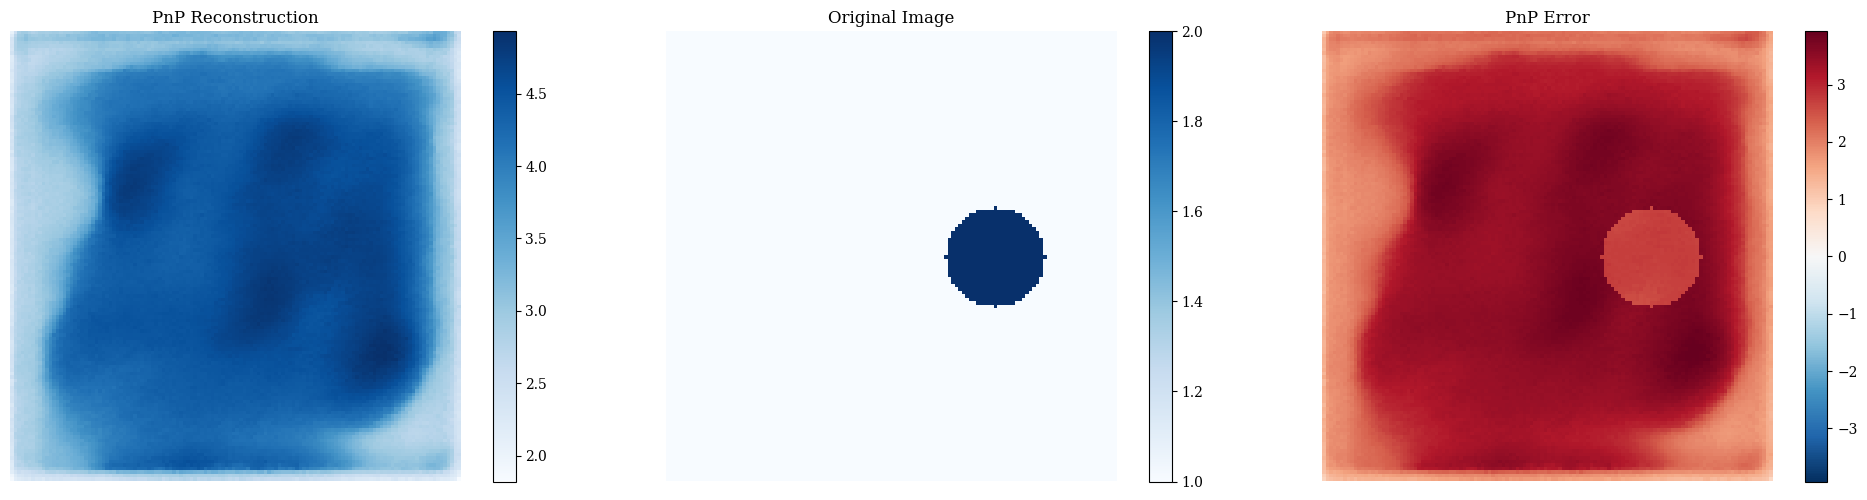

In [68]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore', category=RuntimeWarning)
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams["font.family"] = "DejaVu Serif"
title_font = {"family": "DejaVu Serif", "weight": "bold", "size": 12}
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

im1 = axes[0].imshow(xi.squeeze().detach().cpu().numpy(), cmap="Blues")
axes[0].set_title('PnP Reconstruction')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0])


im3 = axes[1].imshow(gt.squeeze().cpu().numpy(), cmap="Blues")
axes[1].set_title('Original Image')
axes[1].axis('off')
plt.colorbar(im3, ax=axes[1])

error = xi.squeeze().detach().cpu().numpy() - gt.squeeze().cpu().numpy()
im4 = axes[2].imshow(error, cmap='RdBu_r', vmin=-np.abs(error).max(), vmax=np.abs(error).max())
axes[2].set_title('PnP Error')
axes[2].axis('off')
plt.colorbar(im4, ax=axes[2])

plt.tight_layout()
plt.show()

In [69]:
import matplotlib.animation as animation
from IPython.display import HTML
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

gt_img = gt.squeeze().cpu().numpy()

def animate_comparison(frame):
    ax1.clear()
    ax2.clear() 
    ax3.clear()
    
    current_img = xn_trajectory[frame].squeeze()
    
    im1 = ax1.imshow(current_img, cmap="Blues", vmin=gt_img.min(), vmax=gt_img.max())
    ax1.set_title(f'Reconstruction - Step {frame}', fontsize=12)
    ax1.axis('off')

    
    im2 = ax2.imshow(gt_img, cmap="Blues", vmin=gt_img.min(), vmax=gt_img.max())
    ax2.set_title('Ground Truth', fontsize=12)
    ax2.axis('off')
    
    diff = current_img - gt_img
    im3 = ax3.imshow(diff, cmap='RdBu_r', vmin=-np.abs(diff).max(), vmax=np.abs(diff).max())
    ax3.set_title(f'Difference', fontsize=12)
    ax3.axis('off')
    
    return [im1, im2, im3]

frame_indices = list(range(0, len(xn_trajectory), max(1, len(xn_trajectory) // 50)))
anim_comparison = animation.FuncAnimation(fig, animate_comparison, frames=frame_indices, 
                                        interval=300, blit=False, repeat=True)

plt.close(fig)  

html_comparison = HTML(anim_comparison.to_jshtml())
html_comparison